In [1]:
%%capture
!pip install opensmile
!pip install umap-learn
!pip install seaborn

In [2]:
import pandas as pd
import opensmile
from IPython.display import Audio, display
from tqdm import tqdm
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train = pd.read_csv('/data/ASVspoof2024/metadata_trn.txt', sep=' ', names=['Spk_ID','File','Sex','Codec','Attack','Label'])
val = pd.read_csv('/data/ASVspoof2024/ASVspoof5.dev.metadata.txt', sep=' ', names=['Spk_ID','File','Sex','Codec','Attack','Label'])
train['File'] = train['File'].apply(lambda x: '/data/ASVspoof2024/train/' + x + '.flac')
val['File'] = val['File'].apply(lambda x: '/data/ASVspoof2024/flac_D/' + x + '.flac')

In [4]:
def attack(split, idx):
    if split == 'train':
        if isinstance(idx, int):
            assert 0<idx<9
    if split == 'val':
        if isinstance(idx, int):
            assert 8<idx<17
    if isinstance(idx, str):
            assert idx == 'bonafide'
    if split == 'train':
        if isinstance(idx, str):
            return train[train['Attack'] == 'bonafide']
        if isinstance(idx, int):
            return train[train['Attack'] == 'A'+str(idx).zfill(2)]
    if split == 'val':
        if isinstance(idx, str):
            return val[val['Attack'] == 'bonafide']
        if isinstance(idx, int):
            return val[val['Attack'] == 'A'+str(idx).zfill(2)]

In [5]:
def kl_divergence(df1, df2):
    kl_div_values = {}
    columns = df1.columns.intersection(df2.columns)
    
    for col in columns:
        # Extract the column data as numpy arrays
        data1 = df1[col].values
        data2 = df2[col].values
        
        # Remove NaN values if any
        mask = ~np.isnan(data1) & ~np.isnan(data2)
        data1 = data1[mask]
        data2 = data2[mask]
        
        # Compute KL divergence using scipy entropy function
        kl_div = entropy(data1, data2)
        
        # Store the KL divergence value
        kl_div_values[col] = kl_div
    
    return kl_div_values

## Compute GEMAPS

In [70]:
import multiprocessing
from tqdm import tqdm  # Import tqdm for progress bar

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)

# Function that will process elements of the list
def process_element(element):
    # Replace with your processing logic
    return smile.process_file(element)

if __name__ == '__main__':
    # Sample list of elements
    elements = train['File'].to_list()

    # Number of processes to create
    num_processes = multiprocessing.cpu_count()

    # Create a multiprocessing pool
    pool = multiprocessing.Pool(processes=num_processes)

    # Use tqdm for progress bar
    with tqdm(total=len(elements)) as pbar:
        # Map the function to the list elements using the pool
        results = []
        for result in pool.imap_unordered(process_element, elements):
            results.append(result)
            pbar.update(1)

    # Close the pool (no more tasks can be submitted)
    pool.close()

    # Wait for the processes to complete
    pool.join()


100%|██████████| 28190/28190 [13:42<00:00, 34.26it/s]


## Load GEMAPS

In [46]:
egemaps_df_raw =  pd.read_csv('/data/ASVspoof2024/gemaps_train.csv')
egemaps_df_raw = egemaps_df_raw[egemaps_df_raw['file'].isin(train.groupby('Label').sample(n=2500, random_state=42)['File'])]
egemaps_df_raw['Sex'] = egemaps_df_raw['file'].apply(lambda x: train[train['File'] == x].Sex.item())
egemaps_df_raw['Attack'] = egemaps_df_raw['file'].apply(lambda x: train[train['File'] == x].Attack.item())
egemaps_df_raw['Label'] = egemaps_df_raw['file'].apply(lambda x: train[train['File'] == x].Label.item())
egemaps_df_raw = egemaps_df_raw.drop(columns=['file','start','end', 'Unnamed: 0'])
egemaps_df_raw

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,Sex,Attack,Label
40,34.050873,0.114178,30.780794,33.352795,38.006447,7.225653,170.76248,191.409400,44.384785,31.160260,...,4.002809,2.748414,0.163590,0.113465,0.175500,0.126688,-30.421675,F,A06,spoof
52,21.591497,0.304568,19.173632,19.750397,21.444332,2.270700,327.30330,472.034820,104.605736,68.770260,...,4.826958,3.202196,0.112571,0.117530,0.174444,0.151757,-30.189465,M,A04,spoof
80,24.232030,0.427033,18.558506,20.771597,26.462011,7.903505,484.63556,643.400300,236.475920,404.103670,...,3.116344,2.918693,0.090476,0.081473,0.231667,0.359318,-27.183119,M,bonafide,bonafide
149,30.675909,0.170105,26.500084,32.157314,34.401226,7.901142,354.22540,431.076900,84.080620,90.845345,...,3.776130,2.909337,0.143721,0.111398,0.179535,0.187182,-30.508818,F,A03,spoof
176,30.319616,0.208261,25.287415,28.770077,36.112060,10.824646,189.91243,203.462340,133.013950,112.135420,...,3.582317,2.295333,0.136333,0.103392,0.270000,0.268364,-27.569107,M,bonafide,bonafide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182093,24.996044,0.116181,22.541320,25.110920,26.892118,4.350798,138.18082,181.025200,55.390102,90.740570,...,4.231626,2.911534,0.163846,0.083670,0.153333,0.091368,-28.325901,M,A02,spoof
182094,33.025146,0.105438,31.211967,33.096416,34.694332,3.482365,186.33763,205.001020,13.719624,10.960486,...,5.068791,2.543605,0.231143,0.191338,0.137778,0.225722,-24.313837,F,bonafide,bonafide
182106,34.512463,0.076308,32.096973,34.270510,36.384613,4.287640,60.36468,94.936775,20.168873,9.315964,...,2.813599,1.881246,0.258750,0.172514,0.252188,0.370217,-27.904766,F,bonafide,bonafide
182172,29.318497,0.276186,24.422705,26.012903,35.533306,11.110601,363.10687,563.559900,164.466300,102.165410,...,3.823774,2.838064,0.116765,0.082381,0.221212,0.198277,-31.983957,F,A08,spoof


## UMAP

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


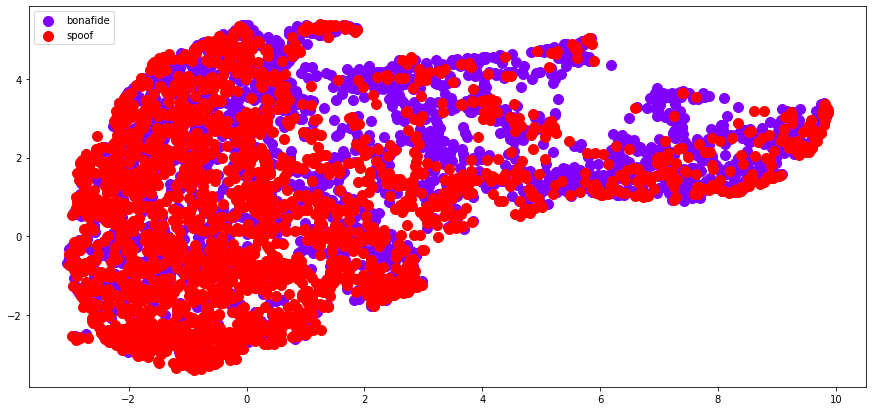

In [47]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_raw.drop(columns=['Sex','Attack','Label']).to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_raw.Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

## Male UMAP

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


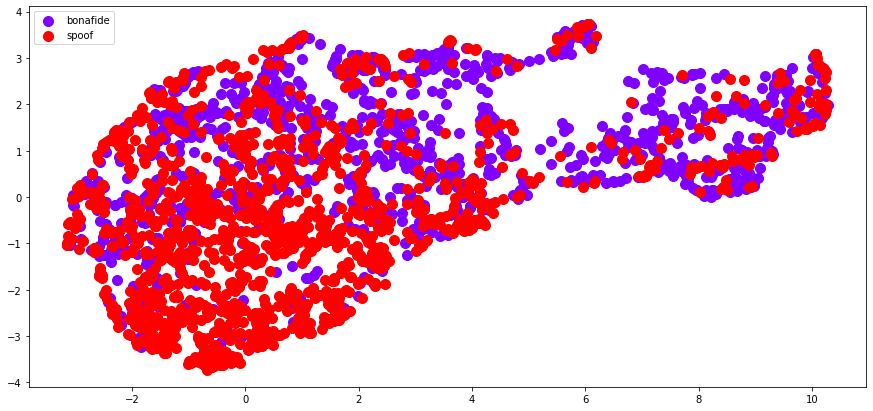

In [48]:
egemaps_df_raw_male = egemaps_df_raw[egemaps_df_raw['Sex'] == 'M']
egemaps_df_raw_male

reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_raw_male.drop(columns=['Sex','Attack','Label']).to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_raw_male[egemaps_df_raw_male['Sex'] == 'M'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

## Female UMAP

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


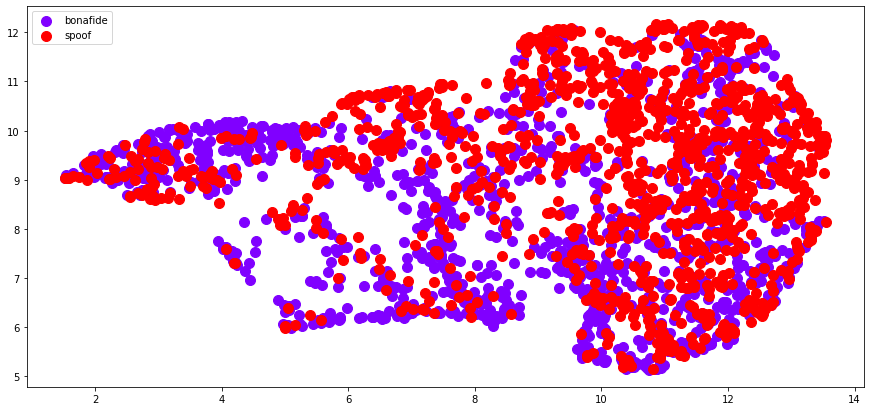

In [49]:
egemaps_df_raw_female = egemaps_df_raw[egemaps_df_raw['Sex'] == 'F']
egemaps_df_raw_female

reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_raw_female.drop(columns=['Sex','Attack','Label']).to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_raw_female[egemaps_df_raw_female['Sex'] == 'F'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

## Min-Max Normalization

In [50]:
scaler = MinMaxScaler()
egemaps_df_norm = pd.DataFrame(scaler.fit_transform(egemaps_df_raw.drop(columns=['Sex','Attack','Label'])), columns=egemaps_df_raw.drop(columns=['Sex','Attack','Label']).columns)
egemaps_df_norm

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
0,0.478009,0.163890,0.490528,0.466107,0.464812,0.153817,0.091819,0.102213,0.107904,0.017618,...,0.668549,0.540394,0.105562,0.547509,0.460742,0.200383,0.088793,0.096305,0.060052,0.381572
1,0.158491,0.510301,0.168164,0.145200,0.067601,0.034278,0.167998,0.252068,0.147609,0.038883,...,0.632745,0.378178,0.183831,0.714747,0.564202,0.115495,0.092644,0.095338,0.077020,0.390199
2,0.226207,0.733123,0.151080,0.169293,0.187940,0.170171,0.244562,0.343578,0.234553,0.228484,...,0.553047,0.461190,0.193862,0.367626,0.499565,0.078731,0.058481,0.147757,0.217501,0.501891
3,0.391459,0.265648,0.371640,0.437903,0.378348,0.170114,0.181099,0.230197,0.134076,0.051365,...,0.565209,0.429156,0.106162,0.501511,0.497432,0.167324,0.086834,0.100001,0.100996,0.378334
4,0.382322,0.335071,0.337961,0.357992,0.419379,0.240644,0.101138,0.108650,0.166339,0.063403,...,0.158559,0.712504,0.142806,0.462182,0.357442,0.155032,0.079249,0.182873,0.155942,0.487551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.245800,0.167534,0.261694,0.271665,0.198256,0.084461,0.075964,0.096668,0.115160,0.051306,...,0.484514,0.565535,0.150260,0.593941,0.497933,0.200809,0.060562,0.075999,0.036147,0.459434
4996,0.451705,0.147987,0.502503,0.460059,0.385377,0.063510,0.099399,0.109471,0.087686,0.006197,...,0.433931,0.523781,0.155248,0.763820,0.414047,0.312782,0.162574,0.061749,0.127081,0.608492
4997,0.489847,0.094987,0.527082,0.487758,0.425916,0.082937,0.038095,0.050697,0.091938,0.005267,...,0.501383,0.501802,0.042495,0.306192,0.263033,0.358717,0.144739,0.166556,0.224878,0.475081
4998,0.356648,0.458660,0.313946,0.292945,0.405499,0.247543,0.185422,0.300943,0.187076,0.057765,...,0.760692,0.801084,0.085513,0.511179,0.481182,0.122472,0.059341,0.138180,0.108505,0.323529


## UMAP

In [51]:
egemaps_df_norm['Sex'] = egemaps_df_raw['Sex'].values
egemaps_df_norm['Attack'] = egemaps_df_raw['Attack'].values
egemaps_df_norm['Label'] = egemaps_df_raw['Label'].values
egemaps_df_norm

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,Sex,Attack,Label
0,0.478009,0.163890,0.490528,0.466107,0.464812,0.153817,0.091819,0.102213,0.107904,0.017618,...,0.547509,0.460742,0.200383,0.088793,0.096305,0.060052,0.381572,F,A06,spoof
1,0.158491,0.510301,0.168164,0.145200,0.067601,0.034278,0.167998,0.252068,0.147609,0.038883,...,0.714747,0.564202,0.115495,0.092644,0.095338,0.077020,0.390199,M,A04,spoof
2,0.226207,0.733123,0.151080,0.169293,0.187940,0.170171,0.244562,0.343578,0.234553,0.228484,...,0.367626,0.499565,0.078731,0.058481,0.147757,0.217501,0.501891,M,bonafide,bonafide
3,0.391459,0.265648,0.371640,0.437903,0.378348,0.170114,0.181099,0.230197,0.134076,0.051365,...,0.501511,0.497432,0.167324,0.086834,0.100001,0.100996,0.378334,F,A03,spoof
4,0.382322,0.335071,0.337961,0.357992,0.419379,0.240644,0.101138,0.108650,0.166339,0.063403,...,0.462182,0.357442,0.155032,0.079249,0.182873,0.155942,0.487551,M,bonafide,bonafide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.245800,0.167534,0.261694,0.271665,0.198256,0.084461,0.075964,0.096668,0.115160,0.051306,...,0.593941,0.497933,0.200809,0.060562,0.075999,0.036147,0.459434,M,A02,spoof
4996,0.451705,0.147987,0.502503,0.460059,0.385377,0.063510,0.099399,0.109471,0.087686,0.006197,...,0.763820,0.414047,0.312782,0.162574,0.061749,0.127081,0.608492,F,bonafide,bonafide
4997,0.489847,0.094987,0.527082,0.487758,0.425916,0.082937,0.038095,0.050697,0.091938,0.005267,...,0.306192,0.263033,0.358717,0.144739,0.166556,0.224878,0.475081,F,bonafide,bonafide
4998,0.356648,0.458660,0.313946,0.292945,0.405499,0.247543,0.185422,0.300943,0.187076,0.057765,...,0.511179,0.481182,0.122472,0.059341,0.138180,0.108505,0.323529,F,A08,spoof


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


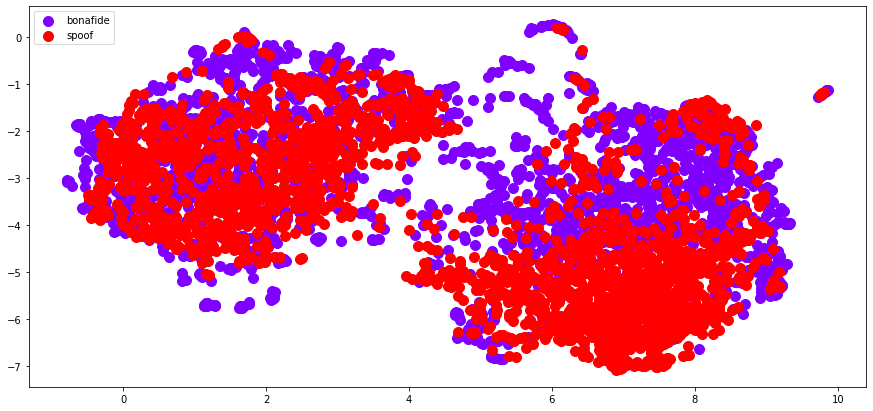

In [52]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm.drop(columns=['Sex','Attack','Label']).to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm.Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

### Gender View

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


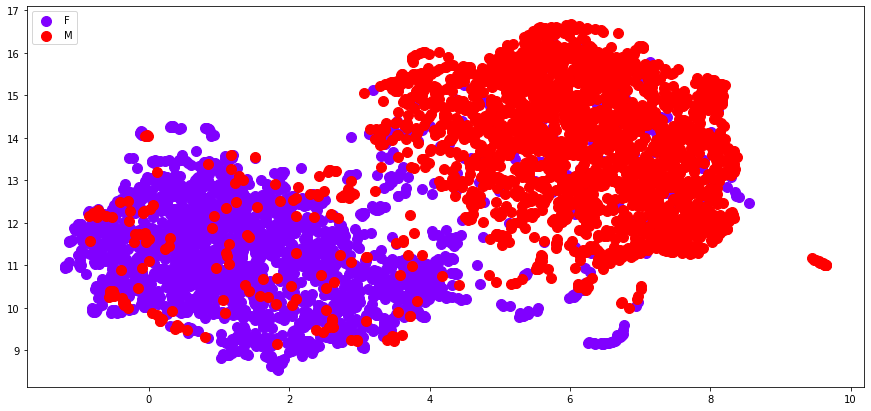

In [53]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm.drop(columns=['Sex','Attack','Label']).to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm.Sex]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

## Male UMAP

In [54]:
egemaps_df_norm_male = egemaps_df_norm[egemaps_df_norm['Sex'] == 'M']
egemaps_df_norm_male

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,Sex,Attack,Label
1,0.158491,0.510301,0.168164,0.145200,0.067601,0.034278,0.167998,0.252068,0.147609,0.038883,...,0.714747,0.564202,0.115495,0.092644,0.095338,0.077020,0.390199,M,A04,spoof
2,0.226207,0.733123,0.151080,0.169293,0.187940,0.170171,0.244562,0.343578,0.234553,0.228484,...,0.367626,0.499565,0.078731,0.058481,0.147757,0.217501,0.501891,M,bonafide,bonafide
4,0.382322,0.335071,0.337961,0.357992,0.419379,0.240644,0.101138,0.108650,0.166339,0.063403,...,0.462182,0.357442,0.155032,0.079249,0.182873,0.155942,0.487551,M,bonafide,bonafide
5,0.307506,0.245028,0.332566,0.312281,0.261115,0.086129,0.122627,0.205922,0.126931,0.061908,...,0.624715,0.534922,0.175553,0.103403,0.083054,0.089680,0.414822,M,A06,spoof
8,0.184721,0.109036,0.217683,0.209285,0.134467,0.058525,0.085147,0.088778,0.093676,0.007328,...,0.515720,0.454648,0.254524,0.073829,0.064618,0.039127,0.528879,M,A07,spoof
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4987,0.377703,0.208680,0.389066,0.394190,0.329583,0.105923,0.119027,0.128233,0.105808,0.025318,...,0.532094,0.436693,0.192373,0.096943,0.114535,0.124203,0.482406,M,bonafide,bonafide
4992,0.163923,0.106463,0.203954,0.185945,0.105296,0.041108,0.092136,0.091516,0.102941,0.023588,...,0.535071,0.415738,0.157805,0.060706,0.144443,0.110308,0.418942,M,A05,spoof
4993,0.332728,0.209399,0.371523,0.347074,0.295924,0.087304,0.124536,0.129119,0.161879,0.124870,...,0.793974,0.729516,0.079480,0.076145,0.082106,0.076720,0.513757,M,bonafide,bonafide
4995,0.245800,0.167534,0.261694,0.271665,0.198256,0.084461,0.075964,0.096668,0.115160,0.051306,...,0.593941,0.497933,0.200809,0.060562,0.075999,0.036147,0.459434,M,A02,spoof


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


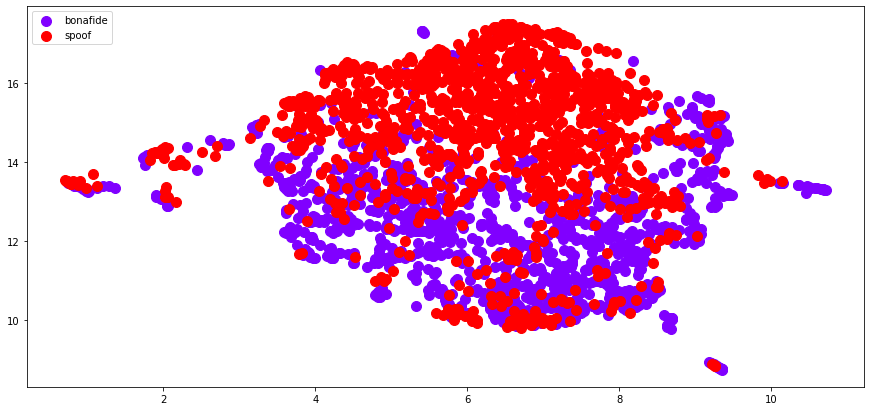

In [55]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm_male.drop(columns=['Sex','Attack','Label']).to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm_male[egemaps_df_norm_male['Sex'] == 'M'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

## Female UMAP

In [56]:
egemaps_df_norm_female = egemaps_df_norm[egemaps_df_norm['Sex'] == 'F']
egemaps_df_norm_female

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,Sex,Attack,Label
0,0.478009,0.163890,0.490528,0.466107,0.464812,0.153817,0.091819,0.102213,0.107904,0.017618,...,0.547509,0.460742,0.200383,0.088793,0.096305,0.060052,0.381572,F,A06,spoof
3,0.391459,0.265648,0.371640,0.437903,0.378348,0.170114,0.181099,0.230197,0.134076,0.051365,...,0.501511,0.497432,0.167324,0.086834,0.100001,0.100996,0.378334,F,A03,spoof
6,0.299838,0.373311,0.280912,0.279385,0.269830,0.139766,0.036390,0.028851,0.232455,0.208698,...,0.245636,0.310762,0.248486,0.176599,0.178293,0.196124,0.491333,F,bonafide,bonafide
7,0.418312,0.082590,0.464080,0.424461,0.363873,0.075255,0.045850,0.056625,0.095239,0.011706,...,0.546455,0.502684,0.174036,0.075788,0.093884,0.096938,0.488064,F,bonafide,bonafide
9,0.503091,0.160629,0.546245,0.487646,0.466060,0.106673,0.040480,0.024186,0.106590,0.029025,...,0.613646,0.350658,0.364957,0.207287,0.076907,0.068151,0.516754,F,bonafide,bonafide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,0.535802,0.283510,0.591009,0.541660,0.474318,0.076095,0.244132,0.258504,0.187430,0.139542,...,0.659424,0.429405,0.159885,0.085130,0.145056,0.109508,0.405956,F,bonafide,bonafide
4994,0.495173,0.147348,0.518336,0.483885,0.466495,0.131354,0.100433,0.131342,0.100146,0.018039,...,0.625157,0.612572,0.170721,0.090649,0.055428,0.074442,0.443024,F,bonafide,bonafide
4996,0.451705,0.147987,0.502503,0.460059,0.385377,0.063510,0.099399,0.109471,0.087686,0.006197,...,0.763820,0.414047,0.312782,0.162574,0.061749,0.127081,0.608492,F,bonafide,bonafide
4997,0.489847,0.094987,0.527082,0.487758,0.425916,0.082937,0.038095,0.050697,0.091938,0.005267,...,0.306192,0.263033,0.358717,0.144739,0.166556,0.224878,0.475081,F,bonafide,bonafide


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


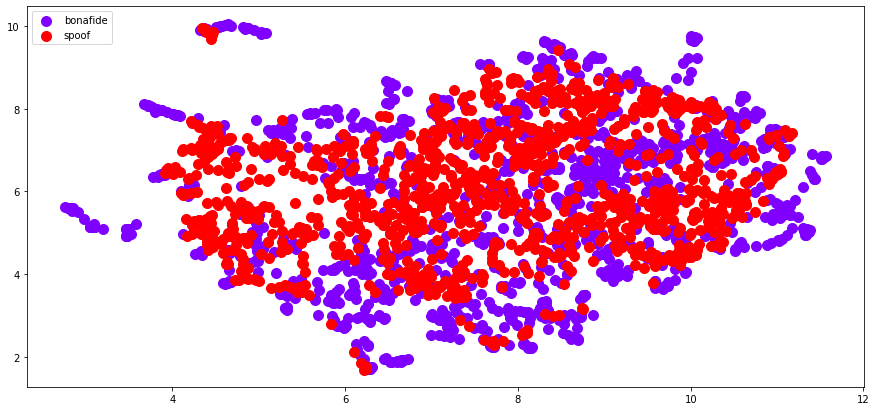

In [57]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm_female.drop(columns=['Sex','Attack','Label']).to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm_female[egemaps_df_norm_female['Sex'] == 'F'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

## Features Selection

Features that comprise the top k maximum KL Divergence between all attack vs bonafide

In [58]:
k=10

In [59]:
M_dict = {}
F = egemaps_df_norm[egemaps_df_norm['Sex'] == 'M']
for atk in F.Attack.unique():
    atk_df = F[F['Attack'] == atk]
    atk_df2 = F[F['Attack'] == 'bonafide']

    M_dict[atk+'_X_'+'bonafide'] = kl_divergence(atk_df.drop(columns=['Sex', 'Attack', 'Label'])[0:min(len(atk_df), len(atk_df2))], atk_df2.drop(columns=['Sex', 'Attack', 'Label'])[0:min(len(atk_df), len(atk_df2))],)

# Initialize list to store top k columns
top_k_columns = []
tok_k_values = []

for idx, row in pd.DataFrame(M_dict).T.iterrows():
    
    if idx == 'bonafide_X_bonafide':
        continue

    # Find columns where max finite value occurs
    max_finite_columns = row.nlargest(k).index.to_list()
    max_fininte_vals = row.nlargest(k).values
    
    # Select top k columns (if there are ties)
    top_k_columns.append(max_finite_columns)
    tok_k_values.append(max_fininte_vals)

feat_M = set([item for sublist in top_k_columns for item in sublist])

F_dict = {}
F = egemaps_df_norm[egemaps_df_norm['Sex'] == 'F']
for atk in F.Attack.unique():
    atk_df = F[F['Attack'] == atk]
    atk_df2 = F[F['Attack'] == 'bonafide']

    F_dict[atk+'_X_'+'bonafide'] = kl_divergence(atk_df.drop(columns=['Sex', 'Attack', 'Label'])[0:min(len(atk_df), len(atk_df2))], atk_df2.drop(columns=['Sex', 'Attack', 'Label'])[0:min(len(atk_df), len(atk_df2))],)


# Initialize list to store top k columns
top_k_columns = []

for idx, row in pd.DataFrame(F_dict).T.iterrows():
    
    if idx == 'bonafide_X_bonafide':
        continue

    # Find columns where max finite value occurs
    max_finite_columns = row.nlargest(k).index.to_list()
    max_fininte_vals = row.nlargest(k).values
    
    # Select top k columns (if there are ties)
    top_k_columns.append(max_finite_columns)

feat_F = set([item for sublist in top_k_columns for item in sublist])


In [60]:
pd.DataFrame(M_dict).T

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp
A04_X_bonafide,0.153710,0.427697,0.144767,0.128660,inf,0.705643,0.649450,0.880369,0.176910,1.562979,...,0.077691,0.036765,0.225328,0.059084,0.070687,0.176349,0.176116,0.347129,0.426586,0.041919
bonafide_X_bonafide,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A06_X_bonafide,0.151022,0.332396,0.152160,0.132955,inf,0.350221,0.409534,0.679148,0.113259,1.440455,...,0.079212,0.042462,0.245105,0.066474,0.057065,0.186133,0.166422,0.280497,0.313438,0.037724
A07_X_bonafide,0.087270,0.252728,0.101304,0.071199,inf,0.258608,0.406051,0.670770,0.090809,1.352062,...,0.074553,0.032821,0.237947,0.068659,0.052566,0.108697,0.103127,0.227034,0.232156,0.032407
A01_X_bonafide,0.124972,0.394617,0.122361,0.099228,inf,0.329753,0.584191,0.964339,0.122536,1.341743,...,0.064993,0.033532,0.257889,0.067716,0.058414,0.181553,0.188427,0.249857,0.284815,0.044408
A05_X_bonafide,0.129413,0.381012,0.133654,0.111515,inf,0.241608,0.518373,0.840351,0.105017,1.170215,...,0.067617,0.037021,0.217264,0.061099,0.045070,0.164707,0.152804,0.233823,0.299467,0.036115
A08_X_bonafide,0.119946,0.345284,0.145311,0.102628,inf,0.333954,0.528280,0.783009,0.144943,1.639318,...,0.069027,0.025574,0.243418,0.079994,0.066713,0.144789,0.148266,0.197994,0.197627,0.028437
A03_X_bonafide,0.091060,0.427203,0.099854,0.080942,inf,0.346284,0.551374,0.882523,0.121515,1.199375,...,0.073547,0.042336,0.236810,0.070422,0.056487,0.156470,0.138916,0.208374,0.240390,0.043894
A02_X_bonafide,0.092599,0.379158,0.097395,0.079553,inf,0.238875,0.405304,0.713128,0.202961,2.174511,...,0.065396,0.028621,0.219916,0.061920,0.044346,0.159145,0.152407,0.210116,0.238610,0.037145


In [61]:
feat_F

{'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F1bandwidth_sma3nz_stddevNorm',
 'MeanUnvoicedSegmentLength',
 'StddevUnvoicedSegmentLength',
 'loudness_sma3_percentile20.0',
 'mfcc4V_sma3nz_amean',
 'mfcc4_sma3_amean',
 'spectralFluxUV_sma3nz_amean'}

In [62]:
feat_M

{'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm',
 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
 'F2bandwidth_sma3nz_amean',
 'MeanUnvoicedSegmentLength',
 'StddevUnvoicedSegmentLength',
 'jitterLocal_sma3nz_stddevNorm',
 'loudness_sma3_percentile20.0',
 'spectralFluxUV_sma3nz_amean'}

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


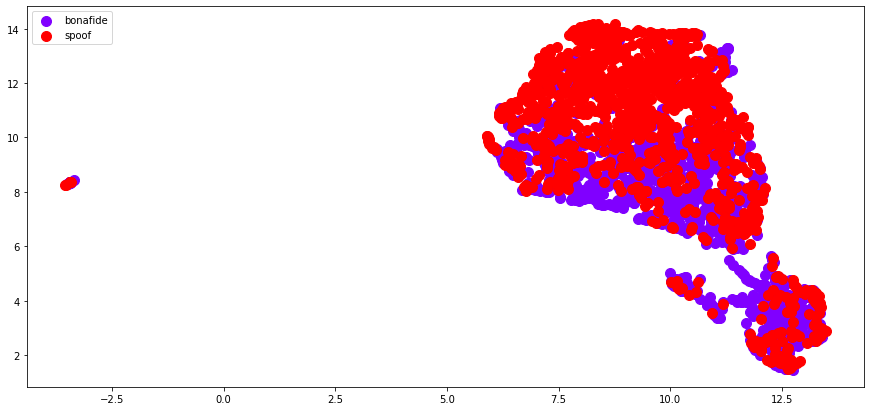

In [63]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm[egemaps_df_norm['Sex'] =='M'][list(feat_M)].to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm[egemaps_df_norm['Sex'] == 'M'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


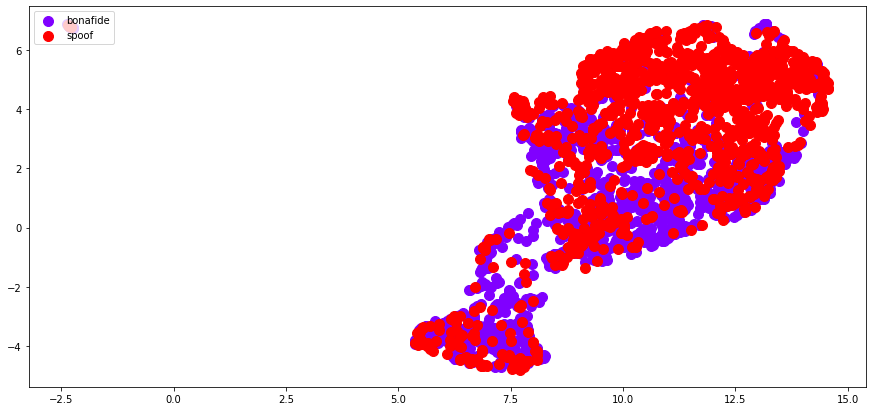

In [64]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm[egemaps_df_norm['Sex'] =='M'][list(feat_F)].to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm[egemaps_df_norm['Sex'] == 'M'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


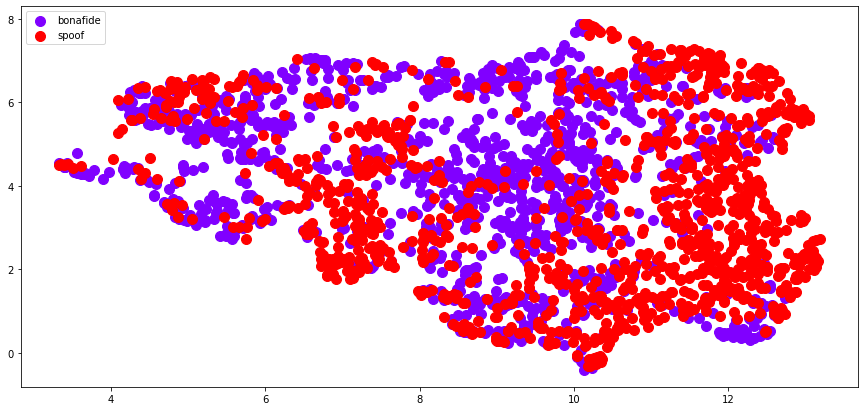

In [65]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm[egemaps_df_norm['Sex'] =='F'][list(feat_F)].to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm[egemaps_df_norm['Sex'] == 'F'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


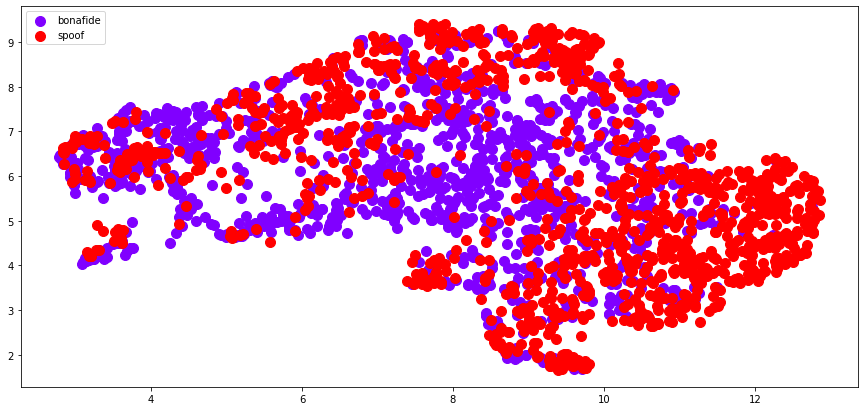

In [66]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm[egemaps_df_norm['Sex'] =='F'][list(feat_M)].to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm[egemaps_df_norm['Sex'] == 'F'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

Features that comprise the top K minimum KL Divergence between all attack vs bonafide

In [67]:
k = 10

In [68]:
M_dict = {}
F = egemaps_df_norm[egemaps_df_norm['Sex'] == 'M']
for atk in F.Attack.unique():
    atk_df = F[F['Attack'] == atk]
    atk_df2 = F[F['Attack'] == 'bonafide']

    M_dict[atk+'_X_'+'bonafide'] = kl_divergence(atk_df.drop(columns=['Sex', 'Attack', 'Label'])[0:min(len(atk_df), len(atk_df2))], atk_df2.drop(columns=['Sex', 'Attack', 'Label'])[0:min(len(atk_df), len(atk_df2))],)

# Initialize list to store top k columns
top_k_columns = []
tok_k_values = []

for idx, row in pd.DataFrame(M_dict).T.iterrows():
    
    if idx == 'bonafide_X_bonafide':
        continue

    # Find columns where max finite value occurs
    max_finite_columns = row.nsmallest(k).index.to_list()
    max_fininte_vals = row.nsmallest(k).values
    
    # Select top k columns (if there are ties)
    top_k_columns.append(max_finite_columns)
    tok_k_values.append(max_fininte_vals)

feat_M = set([item for sublist in top_k_columns for item in sublist])

F_dict = {}
F = egemaps_df_norm[egemaps_df_norm['Sex'] == 'F']
for atk in F.Attack.unique():
    atk_df = F[F['Attack'] == atk]
    atk_df2 = F[F['Attack'] == 'bonafide']

    F_dict[atk+'_X_'+'bonafide'] = kl_divergence(atk_df.drop(columns=['Sex', 'Attack', 'Label'])[0:min(len(atk_df), len(atk_df2))], atk_df2.drop(columns=['Sex', 'Attack', 'Label'])[0:min(len(atk_df), len(atk_df2))],)


# Initialize list to store top k columns
top_k_columns = []

for idx, row in pd.DataFrame(F_dict).T.iterrows():
    
    if idx == 'bonafide_X_bonafide':
        continue

    # Find columns where max finite value occurs
    max_finite_columns = row.nsmallest(k).index.to_list()
    max_fininte_vals = row.nsmallest(k).values
    
    # Select top k columns (if there are ties)
    top_k_columns.append(max_finite_columns)

feat_F = set([item for sublist in top_k_columns for item in sublist])

In [69]:
feat_F

{'HNRdBACF_sma3nz_stddevNorm',
 'alphaRatioV_sma3nz_stddevNorm',
 'logRelF0-H1-A3_sma3nz_stddevNorm',
 'logRelF0-H1-H2_sma3nz_stddevNorm',
 'mfcc1V_sma3nz_stddevNorm',
 'mfcc1_sma3_stddevNorm',
 'mfcc2V_sma3nz_stddevNorm',
 'mfcc2_sma3_stddevNorm',
 'mfcc3V_sma3nz_stddevNorm',
 'mfcc4V_sma3nz_stddevNorm',
 'mfcc4_sma3_stddevNorm',
 'slopeV0-500_sma3nz_stddevNorm'}

In [70]:
feat_M

{'alphaRatioV_sma3nz_stddevNorm',
 'logRelF0-H1-A3_sma3nz_stddevNorm',
 'logRelF0-H1-H2_sma3nz_stddevNorm',
 'mfcc1V_sma3nz_stddevNorm',
 'mfcc1_sma3_stddevNorm',
 'mfcc2V_sma3nz_stddevNorm',
 'mfcc2_sma3_stddevNorm',
 'mfcc3V_sma3nz_stddevNorm',
 'mfcc3_sma3_stddevNorm',
 'mfcc4V_sma3nz_stddevNorm',
 'mfcc4_sma3_stddevNorm',
 'slopeV0-500_sma3nz_stddevNorm',
 'slopeV500-1500_sma3nz_stddevNorm'}

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


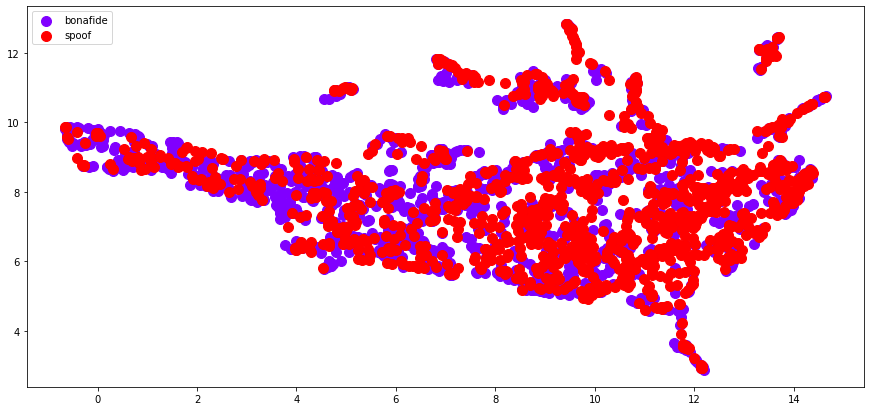

In [71]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm[egemaps_df_norm['Sex'] =='M'][list(feat_M)].to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm[egemaps_df_norm['Sex'] == 'M'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


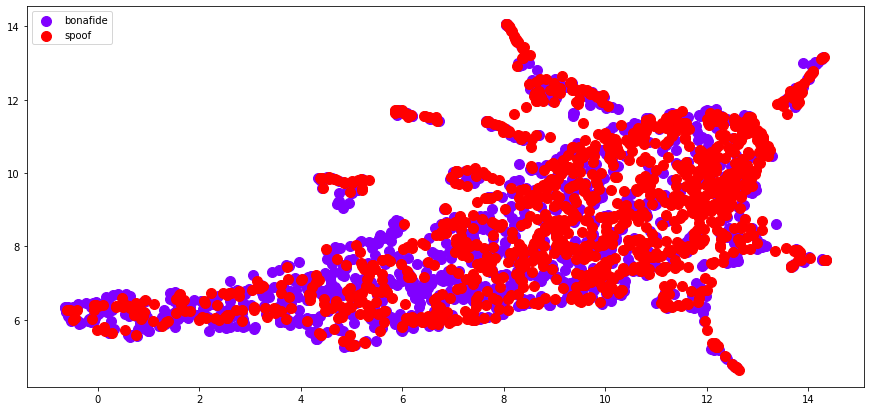

In [72]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm[egemaps_df_norm['Sex'] =='M'][list(feat_F)].to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm[egemaps_df_norm['Sex'] == 'M'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


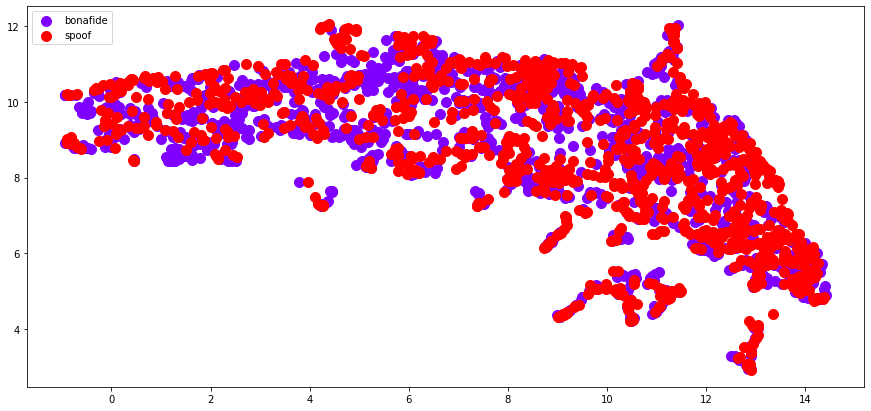

In [73]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm[egemaps_df_norm['Sex'] =='F'][list(feat_F)].to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm[egemaps_df_norm['Sex'] == 'F'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


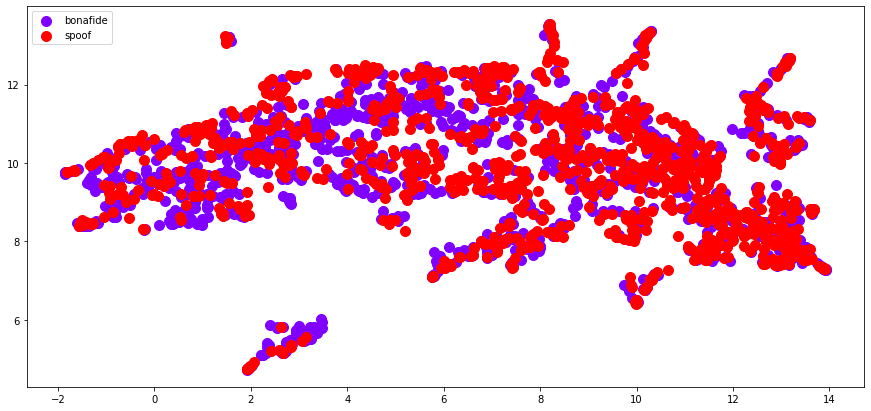

In [74]:
reducer = umap.UMAP()
embeddings = reducer.fit_transform(egemaps_df_norm[egemaps_df_norm['Sex'] =='F'][list(feat_M)].to_numpy())

x = embeddings[:,0]
y = embeddings[:,1]

classes = [x for x in egemaps_df_norm[egemaps_df_norm['Sex'] == 'F'].Label]
s=100
unique = np.unique(classes)
colors = [plt.cm.rainbow(i/float(len(unique)-1)) for i in range(len(unique))]
plt.figure(figsize=(15,7))
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u), s=s)
plt.legend(loc=2, prop={'size': 10})
plt.show()